# __Vehicle Detection__

## 1) Imports

In [1]:
import os
import math
import glob
import cv2
from collections import deque
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import cm
from moviepy.editor import VideoFileClip
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split
from skimage.feature import hog
from scipy.ndimage.measurements import label
import pickle
%matplotlib inline

## 2) Load Test & Dataset Images

Number of non-car images:  8968
Number of car images:  8792
-
Image Location:  ./dataset/vehicles/GTI_Far/image0000.png
Image Shape:  (64, 64, 3)


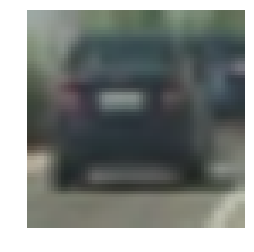

In [2]:
# Test and Calibration images 
test_images = np.array([plt.imread(i) for i in glob.glob('./test_images/*.jpg')])
cali_images = np.array([plt.imread(i) for i in glob.glob('./camera_cal/*.jpg')])
img_size= [1280,720]

# Dataset of non-car and car images

non_car_imgs=[]
car_imgs=[]
pic_extenstion=".png"
car_imgs_dir='./dataset/vehicles/'
non_car_imgs_dir='./dataset/non-vehicles/'

# Small Test Set 
# pic_extenstion=".jpeg"
# car_imgs_dir='./dataset/vehicles_smallset/'
# non_car_imgs_dir='./dataset/non-vehicles_smallset/'

# Traverse entire subdirectories for png image
# Load and store img directory locations,instead of actual images
# Only load the images when processing to save memory , extract_features function 

for root, dirs, files in os.walk(non_car_imgs_dir):
    for file in files:
        if file.endswith(pic_extenstion):
            non_car_imgs.append(os.path.join(root, file))
            
for root, dirs, files in os.walk(car_imgs_dir):
    for file in files:
        if file.endswith(pic_extenstion):
            car_imgs.append(os.path.join(root, file))

# Image Stats
print("Number of non-car images: ",len(non_car_imgs))
print("Number of car images: ",len(car_imgs),)
print ("-")
print ("Image Location: ",car_imgs[0])
image = mpimg.imread(car_imgs[0])
print ("Image Shape: ",image.shape)
plt.imshow(image)
plt.axis("off")
plt.show()

## 2.1) Dataset Visualization

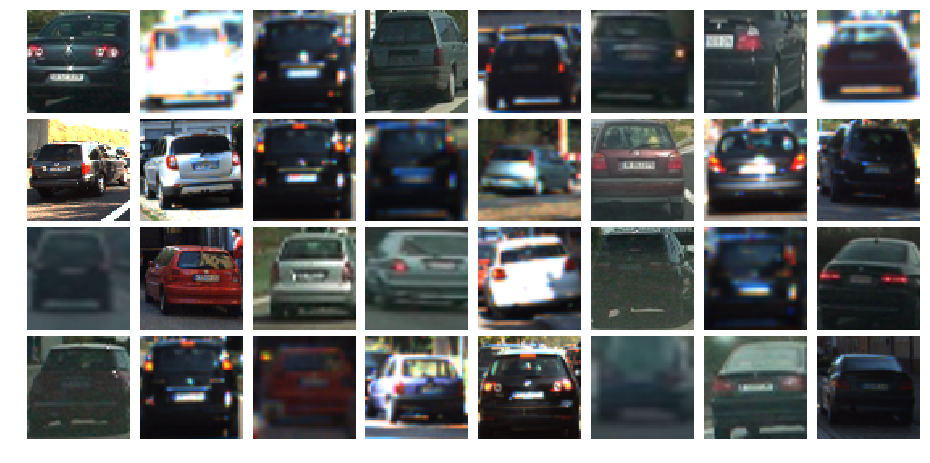

In [3]:
# Car imgs
fig, axs = plt.subplots(4,8, figsize=(16, 8))
fig.subplots_adjust(hspace = 0, wspace=.1)
axs = axs.ravel()

for i in np.arange(32):
    img = cv2.imread(car_imgs[np.random.randint(0,len(car_imgs))])
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    axs[i].axis('off')
    axs[i].imshow(img)
    


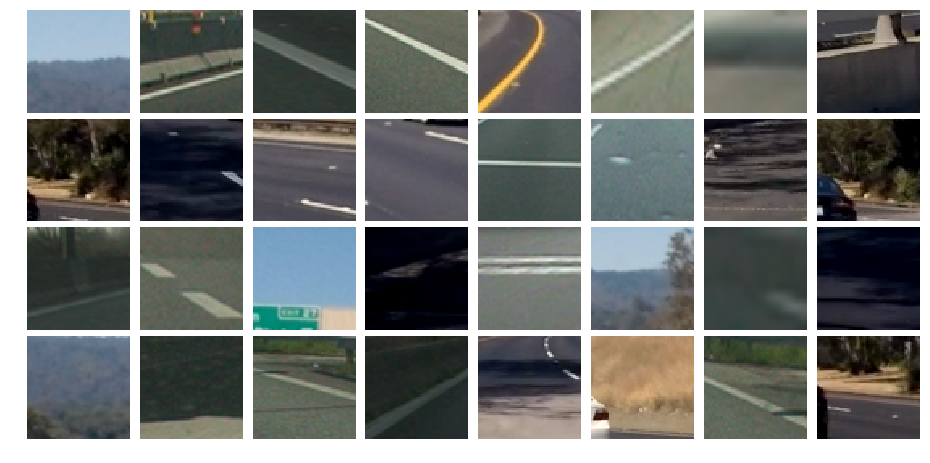

In [4]:
# Non-Car imgs
fig, axs = plt.subplots(4,8, figsize=(16, 8))
fig.subplots_adjust(hspace = 0, wspace=.1)
axs = axs.ravel()

for i in np.arange(32):
    img = cv2.imread(non_car_imgs[np.random.randint(0,len(non_car_imgs))])
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    axs[i].axis('off')
    axs[i].imshow(img)

## 3) Feature Extraction Pipeline

In [5]:
# Compute binned color features by scaling images down 
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features


# Return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Extract feature wrapper that extracts and combines all features
def extract_features(imgs, cspace='RGB', orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0, spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256)):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB' 
            
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)   

        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        
        # Apply bin_spatial() to get spatial color features
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        # Apply color_hist() also with a color space option now
        hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
        # Append the new feature vector to the features list
        features.append(np.concatenate((spatial_features, hist_features,hog_features)))
        
    # Return list of feature vectors
    return features

## 3.1) HOG Visualized 

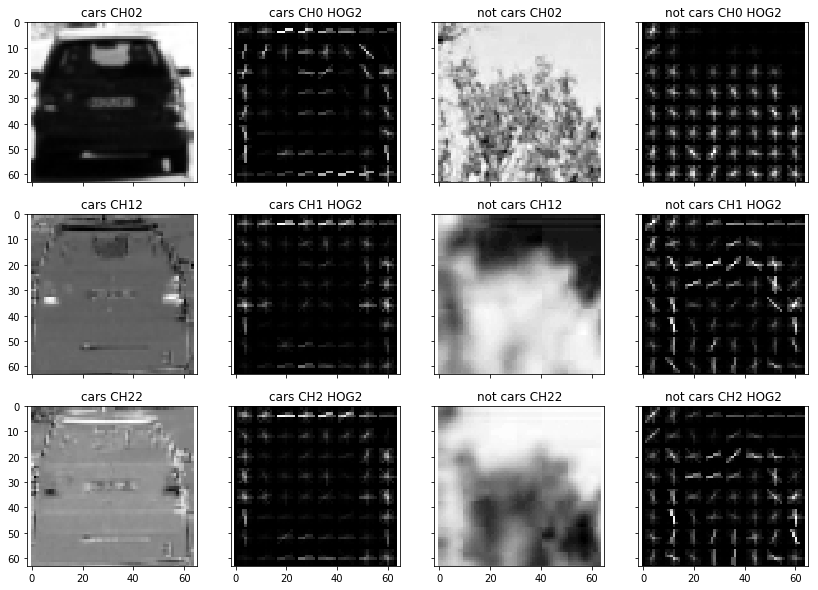

In [6]:
img_cars = mpimg.imread(car_imgs[4000])
img_notcars = mpimg.imread(non_car_imgs[850])
img_cars = cv2.cvtColor(img_cars, cv2.COLOR_RGB2YCrCb)
img_notcars = cv2.cvtColor(img_notcars, cv2.COLOR_RGB2YCrCb)
imgs = []
titles = []
for i in range(3):
    for feature_image, img_type in zip([img_cars, img_notcars], ['cars', 'not cars']):
        channel = feature_image[:,:,i]
        imgs.append(channel)
        titles.append(img_type + ' CH%d' % i)
        features, hog_image = get_hog_features(channel, orient=12, pix_per_cell=8, cell_per_block=2, 
                        vis=True, feature_vec=False)
        imgs.append(hog_image)
        titles.append(img_type + ' CH%d' % i + ' HOG')
        
fig, axes = plt.subplots(3, 4, sharex=True, sharey=True, figsize=(14, 10))
axes = axes.ravel()
for ax, img, title in zip(axes, imgs, titles):
    ax.imshow(img, cmap='Greys_r')
    ax.set_title(title + str(i))
    ax.set_xlim([0, 63])
    ax.set_ylim([0, 63])
    ax.invert_yaxis()

## 3.2) Exploring Colorspaces

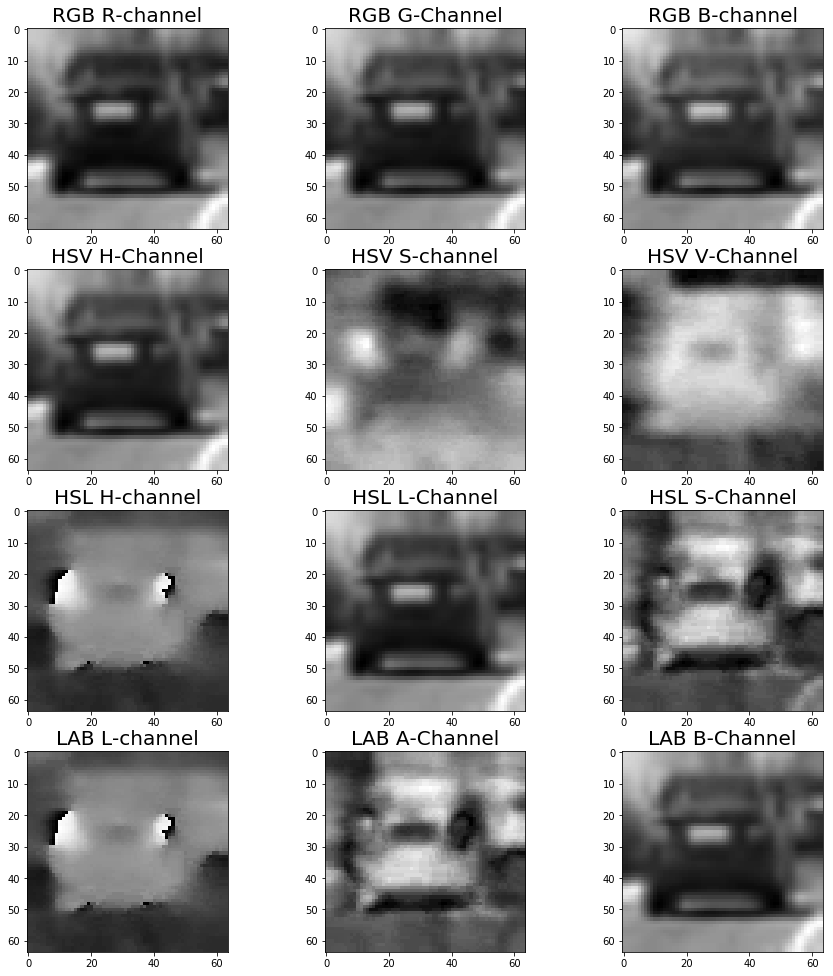

...


In [217]:
def viz_colorspace(img):
    imgRGB_R = img[:,:,0]
    imgRGB_G = img[:,:,1]
    imgRGB_B = img[:,:,2]
    img_HSV = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    imgHSV_H = img_HSV[:,:,0]
    imgHSV_S = img_HSV[:,:,1]
    imgHSV_V = img_HSV[:,:,2]
    img_HLS= cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    imgHLS_H = img_HLS[:,:,0]
    imgHLS_L = img_HLS[:,:,1]
    imgHLS_S = img_HLS[:,:,2]
    img_LAB = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    imgLAB_L = img_LAB[:,:,0]
    imgLAB_A = img_LAB[:,:,1]
    imgLAB_B = img_LAB[:,:,2]
    fig, axs = plt.subplots(4,3, figsize=(16, 17))
    fig.subplots_adjust(hspace = .2, wspace=.001)
    axs = axs.ravel()
    axs[0].imshow(imgRGB_R, cmap='gray')
    axs[0].set_title('RGB R-channel', fontsize=20)
    axs[1].imshow(imgRGB_G, cmap='gray')
    axs[1].set_title('RGB G-Channel', fontsize=20)
    axs[2].imshow(imgRGB_B, cmap='gray')
    axs[2].set_title('RGB B-channel', fontsize=20)
    axs[3].imshow(imgHSV_H, cmap='gray')
    axs[3].set_title('HSV H-Channel', fontsize=20)
    axs[4].imshow(imgHSV_S, cmap='gray')
    axs[4].set_title('HSV S-channel', fontsize=20)
    axs[5].imshow(imgHSV_V, cmap='gray')
    axs[5].set_title('HSV V-Channel', fontsize=20)
    axs[6].imshow(imgHLS_H, cmap='gray')
    axs[6].set_title('HSL H-channel', fontsize=20)
    axs[7].imshow(imgHLS_L, cmap='gray')
    axs[7].set_title('HSL L-Channel', fontsize=20)
    axs[8].imshow(imgHLS_S, cmap='gray')
    axs[8].set_title('HSL S-Channel', fontsize=20)
    axs[9].imshow(imgLAB_L, cmap='gray')
    axs[9].set_title('LAB L-channel', fontsize=20)
    axs[10].imshow(imgLAB_A, cmap='gray')
    axs[10].set_title('LAB A-Channel', fontsize=20)
    axs[11].imshow(imgLAB_B, cmap='gray')
    axs[11].set_title('LAB B-Channel', fontsize=20)
    plt.show()

image = mpimg.imread(car_imgs[0])
viz_colorspace(image)
print('...')

## 3.3) Extract Features 

In [13]:
###========================================###
### Hyperparameters for feature extraction ###
###========================================###

#### Set 1
spatial = 32
histbin = 32
colorspace = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb #YCrCb best
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL" #ALL,0 best


#### Set 2
# spatial = 32
# hist_bins = 64
# colorspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb #YCrCb best
# orient = 11
# pix_per_cell = 8
# cell_per_block = 2
# spatial_size= (32, 32)
# heat_threshold= 10 
# hog_channel = "ALL" # Can be 0, 1, 2, or "ALL" #ALL,0 best
    

car_features = extract_features(car_imgs, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_size=(spatial, spatial),
                        hist_bins=histbin, hist_range=(0, 256))
notcar_features = extract_features(non_car_imgs,cspace=colorspace,orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_size=(spatial, spatial),
                        hist_bins=histbin, hist_range=(0, 256))


## 4) Prepare Data

In [14]:
# Preserve State to compare parameter tuning 
rand_state = np.random.randint(0, 100)

In [15]:
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using spatial binning of:',spatial,'and', histbin,'histogram bins')
print('Feature vector length:', len(X_train[0]))

Using spatial binning of: 32 and 32 histogram bins
Feature vector length: 8460


## 5) Training SVC Classifier


In [16]:
# Use a linear SVC 
svc = LinearSVC()

# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()

print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

# Prediction 
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts:     ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

21.79 Seconds to train SVC...
Test Accuracy of SVC =  0.9873
My SVC predicts:      [ 1.  0.  1.  0.  0.  1.  1.  0.  1.  0.]
For these 10 labels:  [ 1.  0.  1.  0.  0.  1.  1.  0.  1.  0.]
0.02549 Seconds to predict 10 labels with SVC


### 5.1) Save data to pickle file

In [24]:
# Save data to pickle file
dist_pickle = {}
dist_pickle["svc"] = svc
dist_pickle["scaler"] = X_scaler
dist_pickle["orient"] = orient
dist_pickle["pix_per_cell"] = pix_per_cell
dist_pickle["cell_per_block"] = cell_per_block
dist_pickle["spatial"] = spatial
dist_pickle["histbin"] = histbin
pickle.dump(dist_pickle, open("svc_pickle.p", 'wb') )

print('Classifier parameters were saved to file')


Classifier parameters were saved to file


### Load Classifier and Parameters

In [25]:
print('Loading Classifier parameters...')
dist_pickle = pickle.load( open("svc_pickle.p", "rb" ) )
svc = dist_pickle["svc"]
X_scaler = dist_pickle["scaler"]
orient = dist_pickle["orient"]
pix_per_cell = dist_pickle["pix_per_cell"]
cell_per_block = dist_pickle["cell_per_block"]
spatia = dist_pickle["spatial"]
histbin = dist_pickle["histbin"]

print('Loading is done')

Loading Classifier parameters...
Loading is done


## Dashcam Pipeline 

* Camera Calibratio
* Sliding Window Search using HOG subsampling  
* Store results in Heatmap
* Threshold Heatmap
* Draw Bounding Box

## 6) Camera Calibration

In [ ]:
class camera_module():
    """
        Camera class to calibrate camera,store calibration values and perform undistortions
    """
    ret = None
    mtx = None
    dist = None
    rvecs = None
    tvecs = None
    
    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.
    
    def camera_points_generator(self):
        """
            To generate objpoints and imgpoints from calibration images
        """
        # Based on 9x6 chessboard grid size
        objp = np.zeros((6*9,3), np.float32)
        objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)
        # Make a list of calibration images
        images = glob.glob('camera_cal/calibration*.jpg') # Directory
        # Step through the list and search for chessboard corners
        for fname in images:
            img = cv2.imread(fname)
            gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
            # Find the chessboard corners
            ret, corners = cv2.findChessboardCorners(gray, (9,6),None)
            # If found, add object points, image points
            if ret == True:
                self.objpoints.append(objp)
                self.imgpoints.append(corners)
                
    def undistort(self, img):
        """
            Undistorts an image with stored camera matrix
        """
        if self.mtx is None:
            self.ret, self.mtx, self.dist, self.rvecs, self.tvecs = cv2.calibrateCamera(self.objpoints, self.imgpoints,
                                                                                        img.shape[:2],None,None)
        undist = cv2.undistort(img, self.mtx, self.dist, None, self.mtx)
        return undist
    
    def reset_cam(self):
        """
            Reset camera calibration values
        """
        self.ret = None
        self.mtx = None
        self.dist = None
        self.rvecs = None
        self.tvecs = None

## 7) Subsampling HOG Detector

In [223]:
# Extracts features using hog sub-sampling and make predictions
def find_cars(img, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,ystart_ystop_scale,h_shift=800):
    # List of bounding box positions of detections
    bbox_detection_list=[]
    box_viz_list=[]
    # Copy and Normalize
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    
#     ystart_ystop_scale = [(380, 480, 0.9), (400, 600, 1.4), (430, 650, 2.3)]
   
    # Searching different size windows at different scales:
    for (ystart, ystop, scale) in ystart_ystop_scale:
        box_viz=[]
        # Crop
        img_tosearch = img[ystart:ystop,h_shift:,:]
        ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
        if scale != 1:
            imshape = ctrans_tosearch.shape
            ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))

        ch1 = ctrans_tosearch[:,:,0]
        ch2 = ctrans_tosearch[:,:,1]
        ch3 = ctrans_tosearch[:,:,2]

        # Define blocks and steps as above
        nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 3
        nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
        nfeat_per_block = orient*cell_per_block**2

        # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
        window = 64
        nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
        cells_per_step = 2  # Instead of overlap, define how many cells to step
        nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
        nysteps = (nyblocks - nblocks_per_window) // cells_per_step

        # Compute individual channel HOG features for the entire image
        hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)

        for xb in range(nxsteps):
            for yb in range(nysteps):
                ypos = yb*cells_per_step
                xpos = xb*cells_per_step
                # Extract HOG for this patch
                hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

                xleft = xpos*pix_per_cell
                ytop = ypos*pix_per_cell

                # Extract the image patch
                subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))

                # Get color features
                spatial_features = bin_spatial(subimg, size=spatial_size)
                hist_features = color_hist(subimg, nbins=hist_bins)

                # Scale features and make a prediction
                test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
                #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1)) 

                # Make prediction based on trained model 
                test_prediction = svc.predict(test_features)
                
                ############## Visualization
#                 xbox_left = np.int(xleft*scale)
#                 ytop_draw = np.int(ytop*scale)
#                 win_draw = np.int(window*scale)
#                 # Append Detection Position to list 
#                 box_viz.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
               
                ###############
                if test_prediction == 1:
                    xbox_left = np.int(xleft*scale)
                    ytop_draw = np.int(ytop*scale)
                    win_draw = np.int(window*scale)
                    # Append Detection Position to list 
                    bbox_detection_list.append(((xbox_left+h_shift, ytop_draw+ystart),(xbox_left+win_draw+h_shift,ytop_draw+win_draw+ystart)))
                    # Draw Detection on image
                    cv2.rectangle(draw_img,(xbox_left+h_shift, ytop_draw+ystart),(xbox_left+win_draw+h_shift,ytop_draw+win_draw+ystart),(0,0,255),6) 
        box_viz_list += [box_viz]
    return bbox_detection_list,draw_img

## 7.1) Visualize Sliding Windows

(-0.5, 1279.5, 719.5, -0.5)

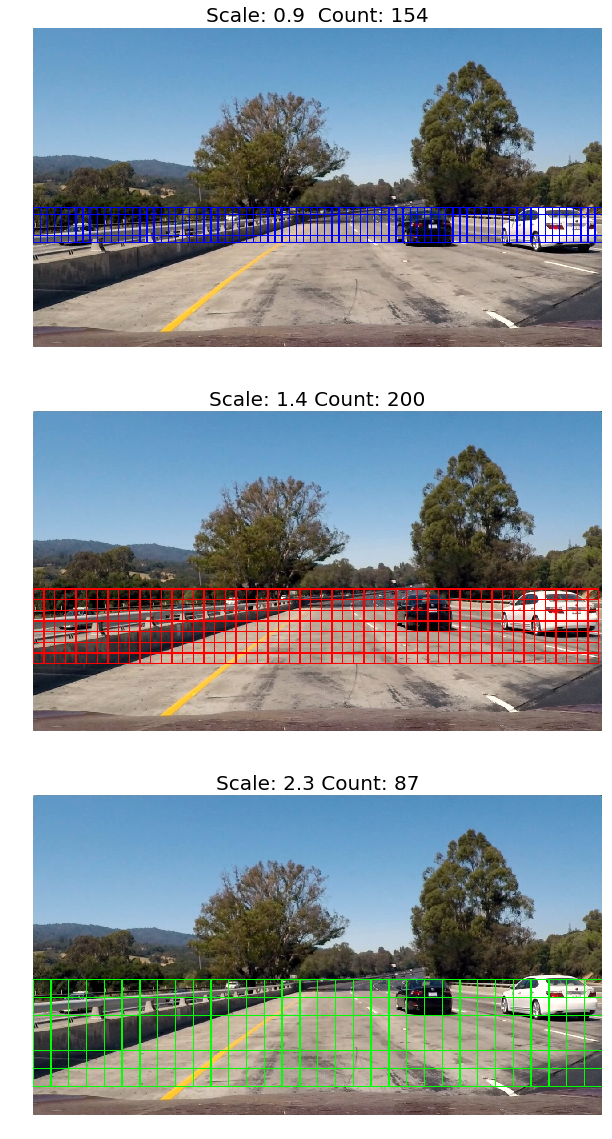

In [222]:
test_image_sliding=test_images[0]
ystart_ystop_scale = [(405, 510, 1), (400, 600, 1.5), (415, 710, 2.5)]
bbox_detection_list,detections,box_viz_list = find_cars(test_image_sliding, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,ystart_ystop_scale)

def draw_boxes(img, bboxes, thickness=2):
    imcopy = [np.copy(img),np.copy(img),np.copy(img)]
    color=[(0, 0, 255),(255, 0, 0),(0, 255, 0)]
    for i in range(len(bboxes)):
        for bbox in bboxes[i]:
            cv2.rectangle(img=imcopy[i], pt1=bbox[0], pt2=bbox[1],
                          color=color[i], thickness=thickness)
    return imcopy

windows_img = draw_boxes(test_image_sliding, box_viz_list)

f, ((ax1, ax2, ax3)) = plt.subplots(3, 1, figsize=(20,20))
ax1.imshow(windows_img[0])
title = "Scale: 0.9 "  + " Count: " + str(len(box_viz_list[0])) 
ax1.set_title(title, fontsize=20)
ax1.axis("off")
ax2.imshow(windows_img[1])
title = "Scale: 1.4"  + " Count: " + str(len(box_viz_list[1])) 
ax2.set_title(title, fontsize=20)
ax2.axis("off")
ax3.imshow(windows_img[2])
title = "Scale: 2.3"  + " Count: " + str(len(box_viz_list[2])) 
ax3.set_title(title, fontsize=20)
ax3.axis("off")

## 8) Heatmap

In [166]:
# Read in image similar to one shown above 
image = test_images[5]
heat = np.zeros_like(image[:,:,0]).astype(np.float)

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold=2):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], (bbox[1][0]+10,bbox[1][1]-10), (0,0,255), 6)
    # Return the image
    return img


# # Add heat to each box in box list
# heat = add_heat(heat,bbox_detection_list)
    
# # Apply threshold to help remove false positives
# heat = apply_threshold(heat,1)

# # Visualize the heatmap when displaying    
# heatmap = np.clip(heat, 0, 255)

# # Find final boxes from heatmap using label function
# labels = label(heatmap)
# draw_img = draw_labeled_bboxes(np.copy(image), labels)

# fig = plt.figure()
# plt.subplot(121)
# plt.imshow(draw_img)
# plt.title('Car Positions')
# plt.subplot(122)
# plt.imshow(heatmap, cmap='hot')
# plt.title('Heat Map')
# fig.tight_layout()


## 9) Debugging View

In [167]:
def build_frame(main,heatmap,detections,heatmap_thres):
    '''
    Stitch together frames for debugging view
    '''
    # Define output image
    # Main image
    img_out=np.zeros((720,1707,3), dtype=np.uint8)
    img_out[0:720,0:1280,:] = main
    
    # Text formatting
    fontScale=1
    thickness=1
    fontFace = cv2.FONT_HERSHEY_DUPLEX   
    
    # Detections image
    img_out[0:240,1281:1707,:] = cv2.resize(detections,(426,240))
    boxsize, _ = cv2.getTextSize("Detections", fontFace, fontScale, thickness)
    cv2.putText(img_out, "Detections", (int(1494-boxsize[0]/2),40), fontFace, fontScale,(255,255,255), thickness,  lineType = cv2.LINE_AA)
   
    # Heatmap image
    heat_img = np.uint8(heatmap*255/(0.001+np.max(heatmap)))
    heat_img = cm.inferno(heat_img)[:,:,:3]*255
    heat_img = heat_img.astype(np.uint8)
    heat_img = cv2.addWeighted(heat_img, 1, main, 0.4, 0)
    img_out[241:481,1281:1707,:] = cv2.resize(heat_img,(426,240))
    boxsize, _ = cv2.getTextSize("Heatmap", fontFace, fontScale, thickness)
    cv2.putText(img_out, "Heatmap", (int(1494-boxsize[0]/2),281), fontFace, fontScale,(255,255,255), thickness,  lineType = cv2.LINE_AA)

    # Thresholded Heatmap lines
    heatmap_img = np.uint8(heatmap_thres*255/(0.001+np.max(heatmap)))
    heatmap_img = cm.inferno(heatmap_img)[:,:,:3]*255
    heatmap_img = heatmap_img.astype(np.uint8)
    heatmap_img = cv2.addWeighted(heatmap_img, 1, main, 0.4, 0)
    img_out[480:720,1281:1707,:] = cv2.resize(heatmap_img,(426,240))
    boxsize, _ = cv2.getTextSize("Heatmap Threshold", fontFace, fontScale, thickness)
    cv2.putText(img_out, "Heatmap Threshold", (int(1494-boxsize[0]/2),521), fontFace, fontScale,(255,255,255), thickness,  lineType = cv2.LINE_AA)
    
    return img_out

## 10) Temporal Heatmap Class

In [204]:
# Accumulation of labels from last N frames
class Detect_history():
    def __init__ (self):
        # Number labels to store
        self.queue_len = 7 #17 13
        self.queue = []

    # Put new frame
    def put_labels(self, labels):
        if (len(self.queue) > self.queue_len):
            tmp = self.queue.pop(0)
        self.queue.append(labels)
    
    # Get last N frames hot boxes
    def get_labels(self):
        detections = []
        for label in self.queue:
            detections.extend(label)
        return detections

## 11) Overall Pipeline

In [205]:
# ###========================================###
### Hyperparameters for feature extraction ###
###========================================###
spatial = 32
hist_bins = 32
colorspace = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb #YCrCb best
orient = 9
pix_per_cell = 8
cell_per_block = 2
spatial_size= (32, 32)
heat_threshold= 4 # 12
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL" #ALL,0 best
ystart_ystop_scale = [(405, 510, 1), (400, 600, 1.5), (500, 710, 2.5)]

# #======Set 2
# spatial = 32
# hist_bins = 64
# colorspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb #YCrCb best
# orient = 11
# pix_per_cell = 8
# cell_per_block = 2
# spatial_size= (32, 32)
# heat_threshold= 10 #10
# hog_channel = "ALL" # Can be 0, 1, 2, or "ALL" #ALL,0 best
    

def process_image(img): 
    
    # Using Subsampled HOG windows to get possible detections 
    bbox_detection_list,detections = find_cars(img, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,ystart_ystop_scale)

    heat = np.zeros_like(img[:,:,0]).astype(np.float)

    # Temporal Heatmap
    detect_history.put_labels(bbox_detection_list)
    bbox_detection_list = detect_history.get_labels()

    # Add heat to detections
    heat_raw = add_heat(heat,bbox_detection_list)
    heat_raw_display = np.copy(heat_raw)
    
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat_raw,heat_threshold)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)

    # Draw bounding box 
    main = draw_labeled_bboxes(np.copy(img), labels)
    
    # Build Debugging View
    result = build_frame(main,heat_raw_display,detections,heatmap)
    
    return result

In [230]:
detect_history = Detect_history()   

(-0.5, 1706.5, 719.5, -0.5)

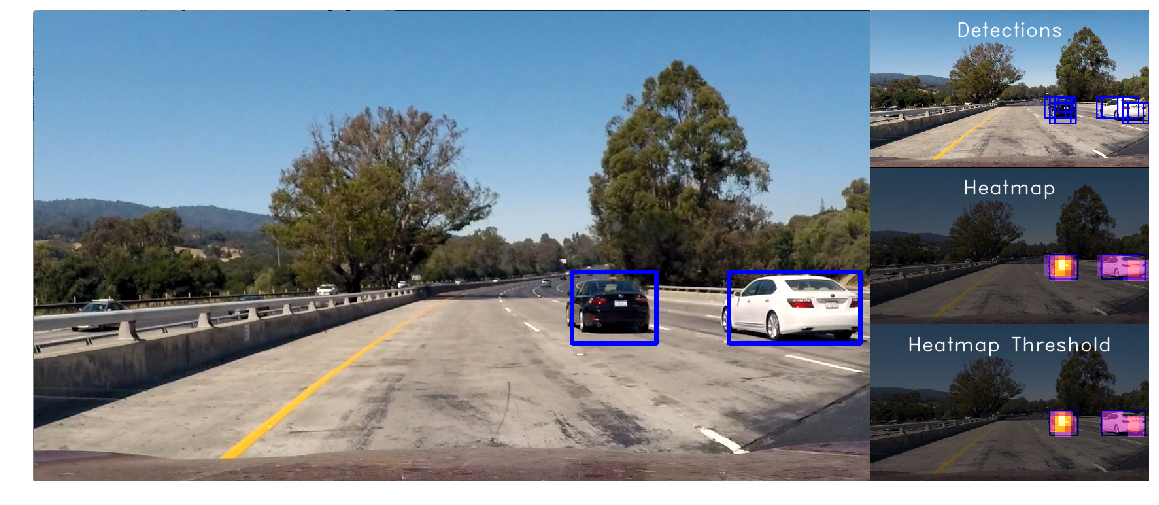

In [233]:
result = process_image(test_images[0])
plt.figure(figsize = (20,20))
plt.imshow(result)
plt.axis("off")

## 12) Process Video

In [ ]:
# Reset and Calibrate
detect_history = Detect_history()
project_video_res = 'project_video_result.mp4'
clip1 = VideoFileClip("project_video.mp4")
project_video_clip = clip1.fl_image(process_image)
project_video_clip.write_videofile(project_video_res, audio=False)